In [20]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from time import time
import matplotlib.pyplot as plt

# Regression 


In [33]:
class RandomForestRegressorCustom: 
    def __init__(self, n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.models = [DecisionTreeRegressor(max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf) for _ in range(n_estimators)]
    def fit(self, X, y):
        for i in range(self.n_estimators):
            indices = np.random.choice(len(X), len(X), replace=True)
            self.models[i].fit(X.iloc[indices], y.iloc[indices])
    def predict(self, X):
        predictions = np.array([model.predict(X) for model in self.models])
        return np.mean(predictions, axis=0)

In [34]:
data_regression = pd.read_csv('data/Housingdata.csv') 
data_regression.fillna(data_regression.mean(), inplace=True)
X_regression = data_regression.drop('MEDV', axis=1)
y_regression = data_regression['MEDV']
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_regression, y_regression, test_size=0.2, random_state=42)

param_grid_regression = {'n_estimators': [10, 50, 100, 200],'max_depth': [None, 10, 20, 30],'min_samples_split': [2, 5, 10],'min_samples_leaf': [1, 2, 4]}
best_mse = float('inf')
best_params_regression = None

for n_estimators in param_grid_regression['n_estimators']:
    for max_depth in param_grid_regression['max_depth']:
        for min_samples_split in param_grid_regression['min_samples_split']:
            for min_samples_leaf in param_grid_regression['min_samples_leaf']:
                rf_regressor = RandomForestRegressorCustom(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)
                rf_regressor.fit(X_train_reg, y_train_reg)
                y_pred_regression = rf_regressor.predict(X_test_reg)
                mse = mean_squared_error(y_test_reg, y_pred_regression)
                if mse < best_mse:
                    best_mse = mse
                    best_params_regression = {'n_estimators': n_estimators, 'max_depth': max_depth, 'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf}

# Train the best Random Forest Regressor
best_rf_regressor = RandomForestRegressorCustom(**best_params_regression)
best_rf_regressor.fit(X_train_reg, y_train_reg)
y_pred_regression = best_rf_regressor.predict(X_test_reg)
mse_regression = mean_squared_error(y_test_reg, y_pred_regression)
print(f"Best Random Forest Regressor Mean Squared Error: {mse_regression}")
print("Best Hyperparameters:", best_params_regression)

Best Random Forest Regressor Mean Squared Error: 11.453710388122355
Best Hyperparameters: {'n_estimators': 10, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 1}


In [58]:
class CustomAdaBoostRegressor: 
    def fit(self, X_train, y_train, num_iterations=100, tree_depth=1, random_state=None):
        # Initialize class variables
        self.target_values = y_train
        self.feature_values = X_train
        self.num_iterations = num_iterations
        self.tree_depth = tree_depth
        self.num_samples, self.num_features = X_train.shape
        self.weights = np.repeat(1/self.num_samples, self.num_samples)
        np.random.seed(random_state)
        self.boosted_trees = []    
        self.fitted_values = np.empty((self.num_samples, self.num_iterations))
        self.betas = []
        for iteration in range(self.num_iterations):
            # Sample with replacement
            bootstrap_indices = np.random.choice(
                np.arange(self.num_samples),
                size=self.num_samples,
                replace=True,
                p=self.weights
            )
            bootstrap_X = self.feature_values[bootstrap_indices]
            bootstrap_y = self.target_values[bootstrap_indices]
            # Fit a decision tree on the bootstrapped sample
            tree = DecisionTreeRegressor(max_depth=self.tree_depth)
            tree.fit(bootstrap_X, bootstrap_y)
            self.boosted_trees.append(tree)
            # Predictions on the training data
            yhat = tree.predict(X_train)
            self.fitted_values[:, iteration] = yhat
            # Calculate observation errors
            absolute_errors = np.abs(self.target_values - yhat)
            D_t = np.max(absolute_errors)
            L_ts = absolute_errors / D_t
            # Calculate model error (and possibly break)
            Lbar_t = np.sum(self.weights * L_ts)
            if Lbar_t >= 0.5:
                self.num_iterations = iteration - 1
                self.fitted_values = self.fitted_values[:, :iteration-1]
                self.boosted_trees = self.boosted_trees[:iteration-1]
                break
            # Calculate and record beta 
            beta_t = Lbar_t / (1 - Lbar_t)
            self.betas.append(beta_t)
            # Reweight
            Z_t = np.sum(self.weights * beta_t ** (1 - L_ts))
            self.weights *= beta_t ** (1 - L_ts) / Z_t
        # Get model weights
        self.model_weights = np.log(1 / np.array(self.betas))
        # Calculate weighted median for training predictions
        self.predictions_train = np.array([
            self.weighted_median(self.fitted_values[n], self.model_weights) for n in range(self.num_samples)
        ])
    
    def predict(self, X_test):
        num_test_samples = len(X_test)
        fitted_values_test = np.empty((num_test_samples, self.num_iterations))
        # Predictions on the test data
        for iteration, tree in enumerate(self.boosted_trees):
            fitted_values_test[:, iteration] = tree.predict(X_test)
        # Calculate weighted median for test predictions
        return np.array([
            self.weighted_median(fitted_values_test[n], self.model_weights) for n in range(num_test_samples)
        ])
    def weighted_median(self, values, weights):
        # Calculate weighted median
        sorted_indices = values.argsort()
        values = values[sorted_indices]
        weights = weights[sorted_indices]
        weights_cumulative_sum = weights.cumsum()
        median_weight = np.argmax(weights_cumulative_sum >= sum(weights) / 2)
        return values[median_weight]
    
class GradientBoostedDecisionTreesRegressor: 
    def fit(self, X_train, y_train, num_iterations=100, learning_rate=0.1, tree_depth=1, random_state=None):
        # Initialize class variables
        self.target_values = y_train
        self.feature_values = X_train
        self.num_iterations = num_iterations
        self.learning_rate = learning_rate
        self.tree_depth = tree_depth
        self.num_samples, self.num_features = X_train.shape
        np.random.seed(random_state)
        self.boosted_trees = []    
        self.fitted_values = np.zeros((self.num_samples, self.num_iterations))
        # Initialize residuals as the target values
        residuals = y_train.copy()
        for iteration in range(self.num_iterations):
            # Fit a decision tree on the residuals
            tree = DecisionTreeRegressor(max_depth=self.tree_depth)
            tree.fit(X_train, residuals)
            self.boosted_trees.append(tree)
            # Predictions on the training data
            yhat = tree.predict(X_train)
            # Update residuals using a fraction (learning_rate) of the predictions
            residuals -= self.learning_rate * yhat
            # Update fitted values
            self.fitted_values[:, iteration] += self.learning_rate * yhat
    def predict(self, X_test):
        num_test_samples = len(X_test)
        fitted_values_test = np.zeros((num_test_samples, self.num_iterations))
        # Predictions on the test data
        for iteration, tree in enumerate(self.boosted_trees):
            fitted_values_test[:, iteration] = self.learning_rate * tree.predict(X_test)
        # Calculate sum of predictions for the final result
        return np.sum(fitted_values_test, axis=1)

In [59]:
data_regression = pd.read_csv('data/Housingdata.csv')
data_regression.fillna(data_regression.mean(), inplace=True)
X_regression = data_regression.drop('MEDV', axis=1)
y_regression = data_regression['MEDV']
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_regression, y_regression, test_size=0.2, random_state=42)

Best Gradient Boosting Classifier MSE  :     5.5256519022695
best AdaBoost Classifier MSE           :     10.762428821804706


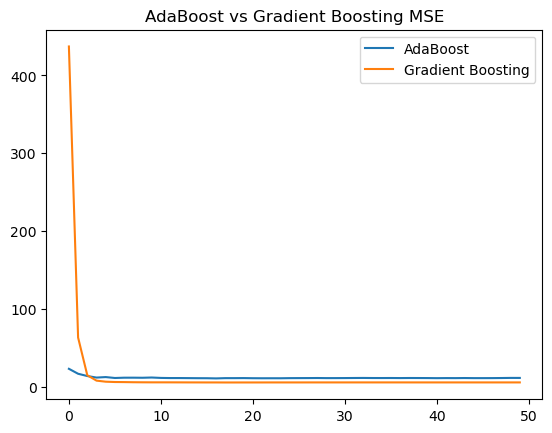

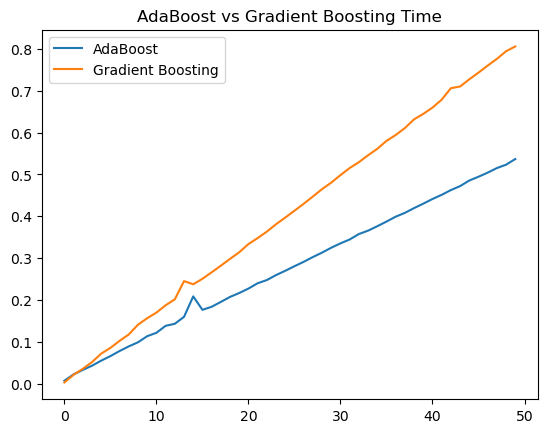

In [61]:
ada_accuracies = [] 
gb_accuracies = []
ada_time = []
gb_time = []
for i in range (1, 500, 10):
    x = time()
    custom_booster = CustomAdaBoostRegressor()
    custom_booster.fit(np.array(X_train_reg), np.array(y_train_reg), num_iterations=i, tree_depth=4, random_state=123)
    preds_reg = custom_booster.predict(np.array(X_test_reg))
    mse_regression = mean_squared_error(y_test_reg, preds_reg)
    ada_accuracies.append(mse_regression)
    ada_time.append(time() - x)
    x = time()
    y_classification = np.array(y_cls)
    gbdt_regressor = GradientBoostedDecisionTreesRegressor()
    gbdt_regressor.fit(np.array(X_train_reg), np.array(y_train_reg), num_iterations=i, learning_rate=0.1, tree_depth=4, random_state=123)
    preds_reg = gbdt_regressor.predict(np.array(X_test_reg))
    mse_regression = mean_squared_error(y_test_reg, preds_reg)
    gb_accuracies.append(mse_regression)
    gb_time.append(time() - x)

print(f"Best Gradient Boosting Classifier MSE  :     {min(gb_accuracies)}")
print(f"best AdaBoost Classifier MSE           :     {min(ada_accuracies)}")
plt.title('AdaBoost vs Gradient Boosting MSE')
plt.plot(ada_accuracies, label='AdaBoost')
plt.plot(gb_accuracies, label='Gradient Boosting')
plt.legend()
plt.show()
plt.title('AdaBoost vs Gradient Boosting Time')
plt.plot(ada_time, label='AdaBoost')
plt.plot(gb_time, label='Gradient Boosting')
plt.legend()

# Classification

In [32]:
class RandomForestClassifierCustom: 
    def __init__(self, n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.models = [DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf) for _ in range(n_estimators)]
    def fit(self, X, y):
        for i in range(self.n_estimators):
            indices = np.random.choice(len(X), len(X), replace=True)
            self.models[i].fit(X.iloc[indices], y.iloc[indices])
    def predict(self, X):
        predictions = np.array([model.predict(X) for model in self.models])
        return np.mean(predictions, axis=0).round().astype(int)

In [27]:
data_classification = pd.read_csv('data/wineQT.csv')
data_classification = data_classification.drop(columns=['Id'])
X_classification = data_classification.drop('quality', axis=1)
y_classification = data_classification['quality']
X_train, X_test, y_train, y_test = train_test_split(X_classification, y_classification, test_size=0.2, random_state=42)

param_grid_classification = {'n_estimators': [10, 50, 100, 200],'max_depth': [None, 10, 20, 30],'min_samples_split': [2, 5, 10],'min_samples_leaf': [1, 2, 4]}

best_accuracy = 0 
best_params_classification = None
for n_estimators in param_grid_classification['n_estimators']:
    for max_depth in param_grid_classification['max_depth']:
        for min_samples_split in param_grid_classification['min_samples_split']:
            for min_samples_leaf in param_grid_classification['min_samples_leaf']:
                rf_classifier = RandomForestClassifierCustom(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)
                rf_classifier.fit(X_train, y_train)
                y_pred_classification = rf_classifier.predict(X_test)
                accuracy = accuracy_score(y_test, y_pred_classification)
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_params_classification = {'n_estimators': n_estimators, 'max_depth': max_depth, 'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf}


# Train the best Random Forest Classifier
best_rf_classifier = RandomForestClassifierCustom(**best_params_classification)
best_rf_classifier.fit(X_train, y_train)
y_pred_classification = best_rf_classifier.predict(X_test)

# Report accuracy
accuracy_classification = accuracy_score(y_test, y_pred_classification)
print(f"Best Random Forest Classifier Accuracy: {accuracy_classification}")
print("Best Hyperparameters:", best_params_classification)


Best Random Forest Classifier Accuracy: 0.6855895196506551
Best Hyperparameters: {'n_estimators': 50, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1}


In [12]:
class AdaBoost: 
    def __init__(self, n_estimators=10, stub_depth=1):
        self.n_estimators = n_estimators
        self.stub_depth = stub_depth

    def fit(self, X_train, y_train):
        self.y_train = y_train
        self.X_train = X_train  
        self.N, self.D = X_train.shape
        self.weights = np.repeat(1 / self.N, self.N)
        self.trees = [] 
        self.alphas = []
        self.yhats = np.empty((self.N, self.n_estimators))
        for t in range(self.n_estimators):
            T_t = DecisionTreeClassifier(max_depth=self.stub_depth)
            T_t.fit(self.X_train, self.y_train, sample_weight=self.weights)
            yhat_t = T_t.predict(self.X_train)
            epsilon_t = sum(self.weights * (yhat_t != self.y_train)) / sum(self.weights)
            alpha_t = 0.5 * np.log((1 - epsilon_t) / max(epsilon_t, 1e-10))
            self.weights = np.array([w * np.exp(-alpha_t * y * yhat) for w, y, yhat in zip(self.weights, self.y_train, yhat_t)])
            self.weights /= np.sum(self.weights)
            self.trees.append(T_t)
            self.alphas.append(alpha_t)
            self.yhats[:, t] = yhat_t 
        self.yhat = np.sign(np.dot(self.yhats, self.alphas))

    def predict(self, X_test):
        yhats = np.zeros(len(X_test))
        for t, tree in enumerate(self.trees):
            yhats_tree = tree.predict(X_test)
            yhats += yhats_tree * self.alphas[t]
        return np.sign(yhats)
    
class GradientBoostingClassifierCustom:
    def __init__(self, n_estimators=50, learning_rate=0.1, max_depth=3):
        self.n_estimators = n_estimators 
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.models = [DecisionTreeRegressor(max_depth=max_depth) for _ in range(n_estimators)]
    def fit(self, X, y):
        f = np.zeros(len(X))
        for i in range(self.n_estimators):
            residuals = y - f
            self.models[i].fit(X, residuals)
            update = self.learning_rate * self.models[i].predict(X)
            f += update
    def predict(self, X):
        predictions = np.array([model.predict(X) for model in self.models])
        return np.round(np.sum(predictions, axis=0))

In [13]:
data_classification = pd.read_csv('data/wineQT.csv')
data_classification = data_classification.drop(columns=['Id'])
X_classification = data_classification.drop('quality', axis=1)
y_classi = data_classification['quality']
y_classi = np.array(y_classi)
y_cls = []
for y in y_classi:
    if y <= 5:
        y = 0
    else:
        y = 1
    y_cls.append(y)
    # print(y)
y_classification = np.array(y_cls)
X_train, X_test, y_train, y_test = train_test_split(X_classification, y_classification, test_size=0.2, random_state=42)

Best Gradient Boosting Classifier Accuracy  :     0.2794759825327511
best AdaBoost Classifier Accuracy           :     0.6855895196506551


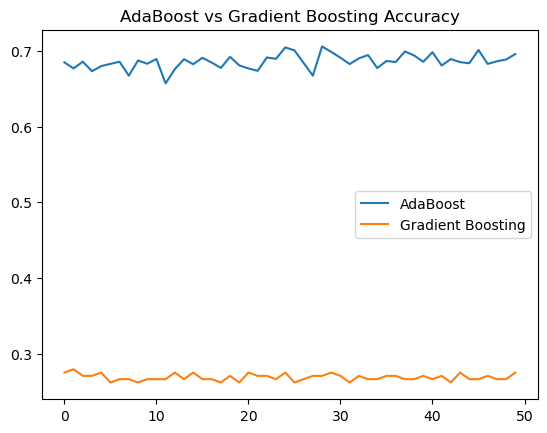

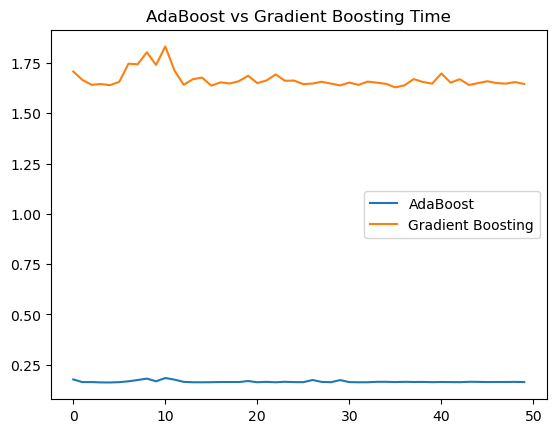

In [23]:
ada_accuracies = []
gb_accuracies = []
ada_time = []
gb_time = []
for i in range (1, 500, 10):
    x = time() 
    ada_classifier = AdaBoost(n_estimators=50)
    ada_classifier.fit(X_train, y_train)
    ada_predictions = ada_classifier.predict(X_test)
    ada_accuracy = accuracy_score(y_test, ada_predictions)
    ada_accuracies.append(ada_accuracy)
    ada_time.append(time() - x)
    x = time()
    y_classification = np.array(y_cls)
    gb_classifier = GradientBoostingClassifierCustom(n_estimators=500, max_depth=None, learning_rate=0.1)
    gb_classifier.fit(X_train, y_train)
    gb_accuracy = accuracy_score(y_test, gb_classifier.predict(X_test))
    gb_accuracies.append(gb_accuracy)
    gb_time.append(time() - x)

print(f"Best Gradient Boosting Classifier Accuracy  :     {max(gb_accuracies)}")
print(f"best AdaBoost Classifier Accuracy           :     {max(ada_accuracies)}")
plt.title('AdaBoost vs Gradient Boosting Accuracy')
plt.plot(ada_accuracies, label='AdaBoost')
plt.plot(gb_accuracies, label='Gradient Boosting')
plt.legend()
plt.show()
plt.title('AdaBoost vs Gradient Boosting Time')
plt.plot(ada_time, label='AdaBoost')
plt.plot(gb_time, label='Gradient Boosting')
plt.legend()

# Model Analysis: RandomForest, Decision Tree AdaBoost, and Gradient Boosting

## RandomForest

RandomForest is an ensemble learning algorithm that builds multiple decision trees and merges them together to get a more accurate and stable prediction. However, it may face challenges in certain scenarios:

- **Common Mistakes:**
  - Tends to overfit if the number of trees is too high.
  - May struggle with capturing complex relationships in the data.

## Decision Tree AdaBoost

AdaBoost, especially with decision trees as base learners, focuses on correcting the mistakes of the previous models. While it's a powerful algorithm, it has its own set of challenges:

- **Common Mistakes:**
  - Sensitive to noisy data and outliers.
  - Can be affected by overfitting if the base learner is too complex.

## Gradient Boosting

Gradient Boosting builds trees sequentially, with each tree correcting the errors of the previous one. It is highly effective but not without its pitfalls:

- **Common Mistakes:**
  - Prone to overfitting, especially if the number of iterations is high.
  - Sensitive to hyperparameter tuning, particularly learning rate and tree depth.

## Feature Similarity of Common Mistakes

The common mistakes in these models can be attributed to the inherent biases in the data or limitations in the algorithmic approach. Feature similarity in mistakes may indicate areas where the models struggle to generalize, and these features could be:

- **Noisy Features:**
  - Features with inconsistent patterns or a high degree of randomness.
- **Outliers:**
  - Instances that deviate significantly from the overall distribution.
- **Complex Interactions:**
  - Features with intricate relationships that require more complex models.

## Classification Tasks: AdaBoost vs. RandomForest vs. Gradient Boosting

- **AdaBoost:**
  - Often excels when the base learner is a weak model.
  - Effective in situations with class imbalance.
  - Tends to focus more on difficult-to-classify instances.

- **RandomForest:**
  - Robust to overfitting due to the ensemble approach.
  - Works well with high-dimensional data.
  - Less sensitive to hyperparameter tuning.

- **Gradient Boosting:**
  - Powerful and flexible, often outperforming RandomForest.
  - Handles complex relationships in the data effectively.
  - Requires careful tuning but can provide high accuracy.

## Regression Tasks: AdaBoost vs. RandomForest vs. Gradient Boosting

- **AdaBoost:**
  - Suitable for regression tasks when the base learner is a regression model.
  - Prone to outliers, affecting performance.

- **RandomForest:**
  - Robust for regression tasks, handling non-linear relationships.
  - Effective in capturing interactions between features.

- **Gradient Boosting:**
  - Often outperforms RandomForest in capturing complex patterns.
  - Sensitive to outliers, but robust in many scenarios.

In summary, the choice between these models depends on the specific characteristics of the dataset and the nature of the task. AdaBoost is strong in classification, RandomForest is versatile, and Gradient Boosting excels in capturing complex relationships for both classification and regression. Careful consideration of data characteristics and model parameters is crucial for optimal performance. 
----
@ChatGPT, Copilot are co-programmers on this.
----